### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a norm-adaption + Fehr-Schmitt model (i.e., simulations, model fitting)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import pickle, datetime
from scipy.stats import norm as norm_dist, beta as beta_dist, gamma as gamma_dist
from tqdm import tqdm
import seaborn as sns

In [3]:
import sys
sys.path.append('C:/Users/fuq01/Documents/GitHub/pyEM')
from pyEM.fitting import EMfit
from pyEM.math import norm2alpha, alpha2norm, compGauss_ms, calc_BICint, calc_LME
from pyEM import plotting
import ug_fixedf0b_models
from ug_fixedf0b_models import RW, norm2f0, beta2norm, norm2envy, norm2beta, envy2norm, norm2beta

# Simulation

In [4]:
# create 30 offers between 1 and 9
offers = np.random.permutation([5, 9, 8, 6, 7, 3, 6, 5, 9, 7, 3, 3, 6, 5, 2, 7, 6, 4, 4, 1, 8, 4, 1, 8, 5, 5, 5, 2, 2, 4])
# plt.hist(offers, bins=9);

In [5]:
modelID = 'sim_FS_varf0'

if modelID == 'sim_fixf0b':
    param_names = ['envy', 'lr']
    objfunc_dict = {modelID: ug_fixedf0b_models.fit}
    beta = False
    f0 = False
elif modelID == 'sim_fixf0b_normed':
    param_names = ['envy', 'lr']
    objfunc_dict = {modelID: ug_fixedf0b_models.fit_RW_f0normed}
    beta = False
    f0 = False
elif modelID == 'sim_fixf0_normed':
    param_names = ['envy', 'lr', 'beta']
    objfunc_dict = {modelID: ug_fixedf0b_models.fit_RW_fixf0}
    beta = True
    f0 = False
elif modelID == 'sim_varf0':
    param_names = ['envy', 'lr', 'f0']
    objfunc_dict = {modelID: ug_fixedf0b_models.fit_RW_varf0} 
    beta = False
    f0 = True
elif modelID == 'sim_FS_varf0':
    param_names = ['envy', 'beta', 'f0']
    objfunc_dict = {modelID: ug_fixedf0b_models.fit_FS_varf0} 

In [6]:
nsubjects = 100
envymin, envymax = .1, 10 #.2, .5
alphamin, alphamax = .1, .9
betamin, betamax = .75, 3 # simulate beta .75 to 3 for FS test
f0min, f0max = .1, 20

params = np.ones((nsubjects, len(param_names)))
for simS in tqdm(range(nsubjects)):
    # For envy, we will sample from a beta distribution and then transform
    if 'envy' in param_names:
        param_idx = param_names.index('envy')
        params[simS, param_idx] = norm2envy(norm_dist.rvs(0, scale=1)) #beta.rvs(1.1, 1.1)
        while params[simS, param_idx] > envymax or params[simS, param_idx] < envymin:
            params[simS, param_idx] = norm2envy(norm_dist.rvs(0, scale=1))#beta.rvs(1.1, 1.1)
        
    # For lr, we will sample from a beta distribution
    if 'lr' in param_names:
        param_idx = param_names.index('lr')
        params[simS, param_idx] = beta_dist.rvs(1.1, 1.1)
        while params[simS, param_idx] > alphamax or params[simS, param_idx] < alphamin:
            params[simS, param_idx] = beta_dist.rvs(1.1, 1.1)
    
    # For beta, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    if 'beta' in param_names:
        param_idx = param_names.index('beta')
        params[simS, param_idx] = norm2beta(norm_dist.rvs(0, scale=1))
        while params[simS, param_idx] > betamax or params[simS, param_idx] < betamin:
            params[simS, param_idx] = norm2beta(norm_dist.rvs(0, scale=1))
            # params[simS, param_idx] = 1 # fix beta
    # For f0, we will sample from a normal distribution and then transform
    # Note: can also use a gamma distribution (`gamma.rvs(1, scale=5)`)
    if 'f0' in param_names:
        param_idx = param_names.index('f0')
        params[simS, param_idx] = norm2f0(norm_dist.rvs(0, scale=1))
        while params[simS, param_idx] > f0max or params[simS, param_idx] < f0min:
            params[simS, param_idx] = norm2f0(norm_dist.rvs(0, scale=1))

100%|██████████| 100/100 [00:00<00:00, 14285.29it/s]


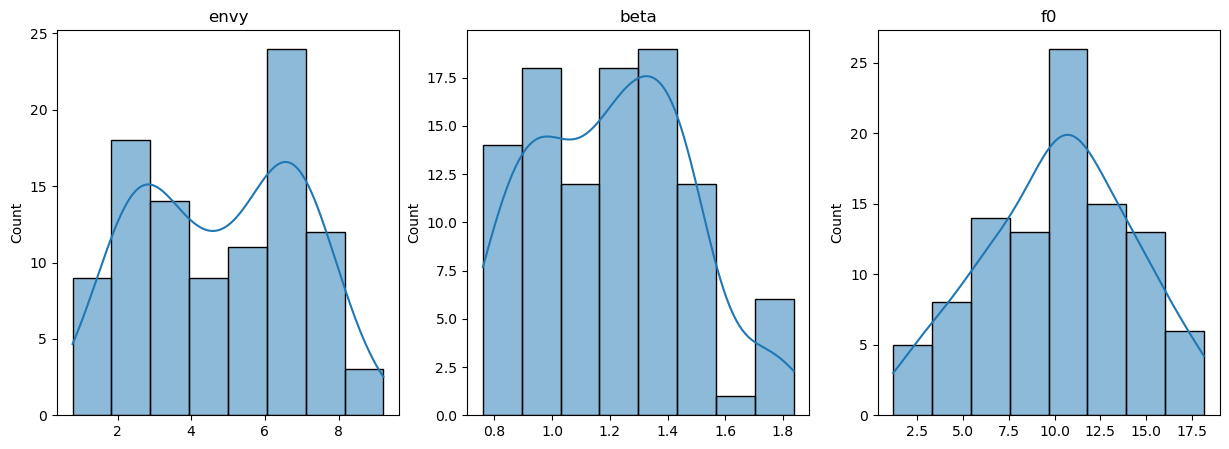

In [7]:
# visualize the simulated parameters distribution
fig, ax = plt.subplots(1, len(param_names), figsize=(15, 5))
for idx, param in enumerate(param_names):
    sns.histplot(params[:, idx], ax=ax[idx], kde=True)
    ax[idx].set_title(param)

In [8]:
simul_dict   = {modelID: ug_fixedf0b_models.simulate_FS}

ntrials, nblocks = 30, 1
print(f'ntrials: {ntrials}, nblocks: {nblocks}')

simulfunc = simul_dict[modelID]
subj_dict = simulfunc(params, offers, nblocks=nblocks, ntrials=ntrials)
# subj_dict = simulfunc(params, np.tile(offers, 2), nblocks=nblocks, ntrials=ntrials*2)

ntrials: 30, nblocks: 1


100%|██████████| 100/100 [00:00<00:00, 1227.48it/s]


## simulation visual check

In [9]:
subj_dict['offers'][20,0,:][subj_dict['choices'][20,0,:]=='R']

array([6., 6., 7., 6., 3., 7., 5., 5., 2., 8., 7., 3., 1., 4., 5., 4., 6.,
       1., 8., 3., 5., 4., 9., 8., 5., 5., 2., 4., 2., 9.])

(array([ 12.,  60., 172., 336., 547., 823., 779., 192.,  57.,  22.]),
 array([-115.16381098,  -97.16296524,  -79.1621195 ,  -61.16127377,
         -43.16042803,  -25.15958229,   -7.15873655,   10.84210919,
          28.84295492,   46.84380066,   64.8446464 ]),
 <BarContainer object of 10 artists>)

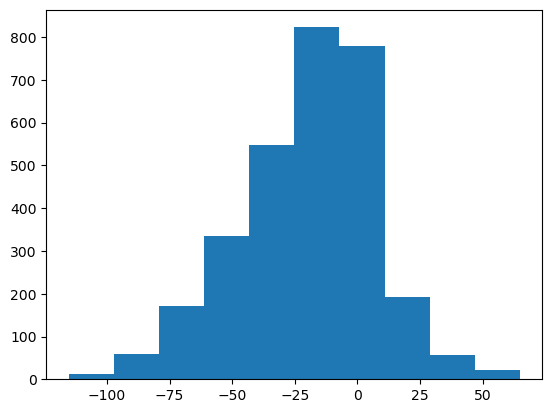

In [10]:
plt.hist(subj_dict['vd'].ravel())

In [11]:
# Assuming your array is named 'arr'
arr = subj_dict['params']

# Normalize column 1 (small values should be lower)
col1_norm = (arr[:, 1] - arr[:, 1].min()) / (arr[:, 1].max() - arr[:, 1].min())

# Normalize column 2 (large values should be higher)
col2_norm = (arr[:, 2] - arr[:, 2].min()) / (arr[:, 2].max() - arr[:, 2].min())

# We want a subject with a small value in column 1 and large value in column 2
# Hence we subtract col1_norm from col2_norm
combination_metric = col2_norm - col1_norm

# Find the index of the subject with the best combination (largest difference)
best_subject_index = np.argmax(combination_metric)

best_subject_index

77

In [12]:
subj_dict['params'][86,:]

array([6.89115229, 0.98814791, 6.04896329])

In [13]:
subj_dict['params'][:,1].min(), 

(0.7598710087458225,)

In [14]:
subj_dict['params'].max()

# get the index of the maximum value in the array
max_index = np.argmax(subj_dict['params'][:,2])
max_index

58

In [15]:
subj_dict['params'][max_index]

array([ 2.95790004,  0.8852857 , 18.16181557])

In [16]:
subj_dict['params'][:,2][max_index]

18.16181556796137

In [17]:
subj_dict['norms'].shape

(100, 1, 31)

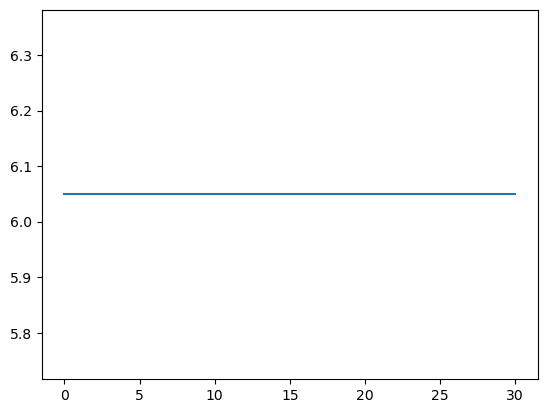

In [18]:
plt.plot(subj_dict['norms'][86,0,:]) #for the max f0 agent 

In [19]:
print(subj_dict.keys())

dict_keys(['params', 'ev', 'vd', 'ch_prob', 'choices', 'choices_A', 'rewards', 'offers', 'norms', 'choice_nll'])


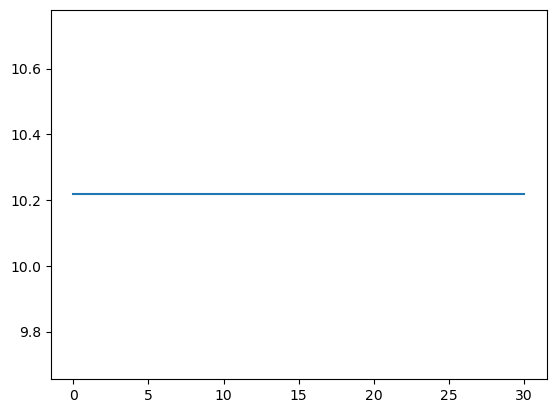

In [20]:
plt.plot(np.mean(subj_dict['norms'][:,0,:],axis=0))

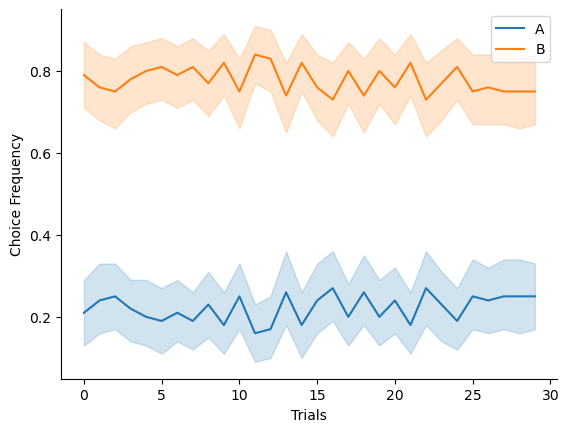

In [21]:
plotting.plot_choices(subj_dict['choices_A']) 

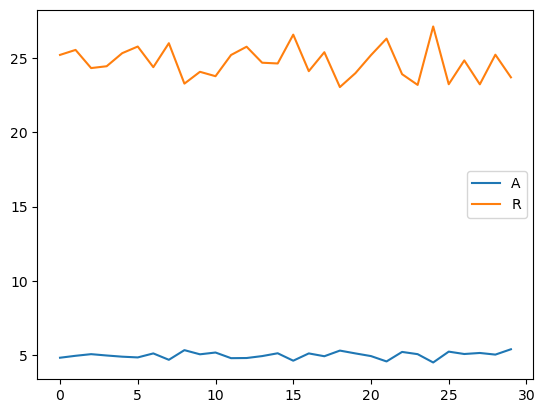

In [22]:
plt.plot(np.mean(subj_dict['ev'][:,0,:,0],axis=0),label='A')
plt.plot(np.mean(subj_dict['ev'][:,0,:,1],axis=0),label='R')
plt.legend()

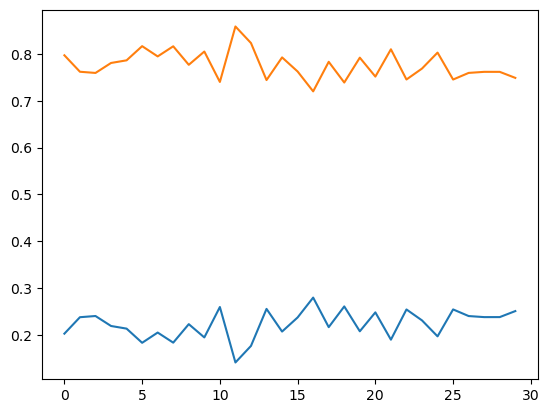

In [23]:
plt.plot(np.mean(subj_dict['ch_prob'][:,0,:],axis=0))

## recovery

In [24]:
# create a list of lists with choices and rewards for each subject for parameter recovery 
all_data = []
for idx, (this_choices, this_offers) in enumerate(zip(subj_dict['choices'], subj_dict['offers'])):
    all_data += [[this_choices, this_offers]]

In [25]:
modelID

'sim_FS_varf0'

In [26]:
m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, objfunc_dict[modelID], param_names, convergence_method='mean')
# normed version est 7m, FS version est 10m 

29.826 (000), 7.202 (001), 6.264 (002), 5.876 (003), 5.637 (004), 5.464 (005), 5.323 (006), 5.208 (007), 5.095 (008), 5.002 (009), 4.926 (010), 4.860 (011), 4.810 (012), 4.758 (013), 4.720 (014), 4.686 (015), 4.657 (016), 4.631 (017), 4.604 (018), 4.575 (019), 4.549 (020), 4.520 (021), 4.492 (022), 4.470 (023), 4.450 (024), 4.417 (025), 4.380 (026), 4.345 (027), 4.317 (028), 4.293 (029), 4.258 (030), 4.218 (031), 4.186 (032), 4.155 (033), 4.128 (034), 4.101 (035), 4.080 (036), 4.059 (037), 4.042 (038), 4.024 (039), 4.010 (040), 4.000 (041), 3.986 (042), 3.975 (043), 3.969 (044), 3.958 (045), 3.946 (046), 3.939 (047), 3.929 (048), 3.925 (049), 3.917 (050), 3.906 (051), 3.893 (052), 3.887 (053), 3.878 (054), 3.868 (055), 3.861 (056), 3.851 (057), 3.843 (058), 3.837 (059), 3.832 (060), 3.820 (061), 3.811 (062), 3.801 (063), 3.795 (064), 3.788 (065), 3.781 (066), 3.771 (067), 3.761 (068), 3.749 (069), 3.741 (070), 3.730 (071), 3.721 (072), 3.712 (073), 3.704 (074), 3.688 (075), 3.672 (076)

In [29]:
## Now store all relevant outputs in modout dict and save it
save_fit = False

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
modout[modelID]['behavior'] = subj_dict  # copy behavior here

# Fill in fit information
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'beta' in param_name:
            est_params[subj_idx, param_idx] = norm2beta(m[param_idx, subj_idx])
        elif 'lr' in param_name:
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])
        elif 'envy' in param_name:
            est_params[subj_idx, param_idx] = norm2envy(m[param_idx, subj_idx])
        elif 'f0' in param_name:
            est_params[subj_idx, param_idx] = norm2f0(m[param_idx, subj_idx])

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior
modout[modelID]['fit']['aic'] = 2*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['bic'] = np.log(ntrials*nblocks)*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['lme'] = []

# Make sure you know if BIC is positive or negative! and replace lme with bic if covariance is negative.
# Error check that BICs are in a similar range
# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials, 2))
modout[modelID]['fit']['vd']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
# modout[modelID]['fit']['pe']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
for subj_idx in range(nsubjects):
    try:
        det_inv_hessian = np.linalg.det(inv_h[:, :, subj_idx])
        hHere = np.linalg.slogdet(inv_h[:, :, subj_idx])[1]
        L = -NPL - 0.5 * np.log(1 / det_inv_hessian) + (nparams / 2) * np.log(2 * np.pi)
        goodHessian[subj_idx] = 1
    except:
        print('Hessian is not positive definite')
        try:
            hHere = np.linalg.slogdet(inv_h[:,:,subj_idx])[1]
            L = np.nan
            goodHessian[subj_idx] = 0
        except:
            print('could not calculate')
            goodHessian[subj_idx] = -1
            L = np.nan
    modout[modelID]['fit']['lme'] = L
    modout[modelID]['fit']['goodHessian'] = goodHessian

    # Get subjectwise model predictions# get info for current subject
    choices = subj_dict['choices'][subj_idx,:,:]
    rewards = subj_dict['rewards'][subj_idx,:,:]
    
    #need to edit here for different models
    if modelID == 'sim_fixf0b':
        model_fits = ug_fixedf0b_models.fit(m[:,subj_idx], choices, rewards, prior=None, output='all')
    elif modelID == 'sim_fixf0b_normed':
        model_fits = ug_fixedf0b_models.fit_RW_f0normed(m[:,subj_idx], choices, rewards, prior=None, output='all')
    elif modelID == 'sim_fixf0_normed':
        model_fits = ug_fixedf0b_models.fit_RW_fixf0(m[:,subj_idx], choices, rewards, prior=None, output='all')
    elif modelID == 'sim_varf0':
        model_fits = ug_fixedf0b_models.fit_RW_varf0(m[:,subj_idx], choices, rewards, prior=None, output='all')
    elif modelID == 'sim_FS_varf0':
        model_fits = ug_fixedf0b_models.fit_FS_varf0(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['vd'][subj_idx,:,:] = model_fits['vd']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    modout[modelID]['fit']['choices_A'][subj_idx,:,:] = model_fits['choices_A']
    modout[modelID]['fit']['rewards'][subj_idx,:,:] = model_fits['rewards']
    # modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

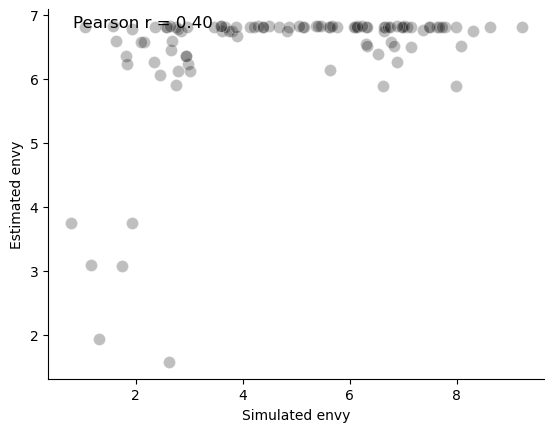

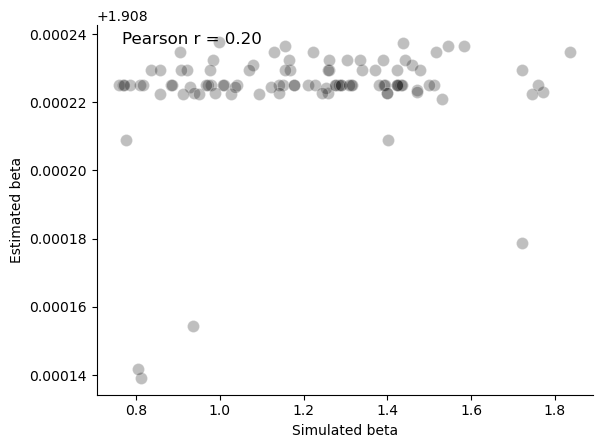

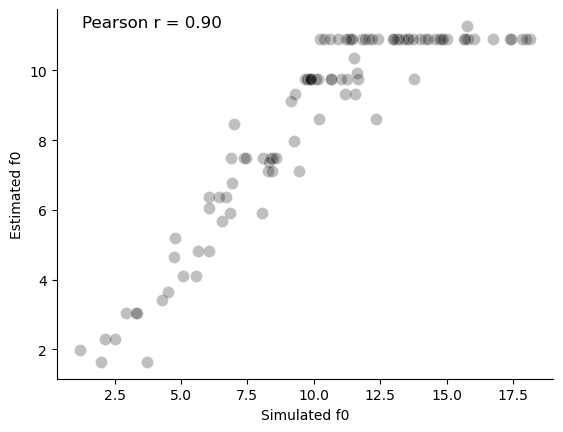

In [30]:
for param_idx, param_label in enumerate(param_names):
    simulated_param = subj_dict['params'][:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}', colorname='black')

## simulated data saving

In [29]:
subj_dict.keys()

dict_keys(['params', 'ev', 'vd', 'ch_prob', 'choices', 'choices_A', 'rewards', 'offers', 'norms', 'choice_nll'])

In [30]:
# Specify the keys you want to select
selected_keys = ['choices', 'choices_A', 'rewards', 'offers', 'norms', 'choice_nll', 'params', 'ev', 'vd']
sub_dict = {key: subj_dict[key] for key in selected_keys if key in subj_dict}

# Iterate over the dictionary and print the shape of each array
for key, array in sub_dict.items():
    print(f"Key: {key}, Shape: {array.shape}")

Key: choices, Shape: (100, 1, 30)
Key: choices_A, Shape: (100, 1, 30)
Key: rewards, Shape: (100, 1, 30)
Key: offers, Shape: (100, 1, 30)
Key: norms, Shape: (100, 1, 31)
Key: choice_nll, Shape: (100, 1, 30)
Key: params, Shape: (100, 3)
Key: ev, Shape: (100, 1, 30, 2)
Key: vd, Shape: (100, 1, 30)


In [31]:
# Assume your dictionary of NumPy arrays (all arrays have shape (219, 3, 35) except params which has shape (219, 2))
data_dict = sub_dict

# Initialize lists to hold the DataFrame content
subject_list = []
block_list = []
trial_list = []
data_dict_flattened = {key: [] for key in data_dict.keys() if key != 'params'}  # Exclude params for now

# Step 1: Flatten the arrays and prepare subject, block, and trial information
for subject in range(data_dict['offers'].shape[0]):  # 219 subjects
    for block in range(data_dict['offers'].shape[1]):  # 3 blocks
        for trial in range(data_dict['offers'].shape[2]):  # 35 trials
            # Append subject, block, and trial information
            subject_list.append(subject)
            block_list.append(block)
            trial_list.append(trial)
            
            # Append the values from each array (except 'params')
            for key in data_dict.keys():
                if key != 'params':
                    data_dict_flattened[key].append(data_dict[key][subject, block, trial])

# Step 2: Create the DataFrame for all keys except 'params'
sim_df = pd.DataFrame({
    'subject': subject_list,
    'block': block_list,
    'trial': trial_list,
})

# Add the flattened values from the dictionary as columns in the DataFrame
for key in data_dict_flattened.keys():
    sim_df[key] = data_dict_flattened[key]

# Step 3: Add param1 and param2 directly to sim_df
params_df = pd.DataFrame(data_dict['params'], columns=param_names)
params_df['subject'] = params_df.index  # Add the subject column

# Step 4: Merge param1 and param2 with sim_df on the subject column
sim_df = pd.merge(sim_df, params_df, on='subject', how='left')
sim_df[['ev_a', 'ev_r']] = pd.DataFrame(sim_df['ev'].tolist(), index=sim_df.index)
sim_df.drop(columns='ev', axis=1, inplace=True)

# View the final DataFrame
sim_df.head(35)

,subject,block,trial,choices,choices_A,rewards,offers,norms,choice_nll,vd,envy,lr,beta,ev_a,ev_r
0,0,0,0,A,1.0,6.0,6.0,0.500000,1.603307e-02,2.542199,2.163316,0.600405,1.622641,6.0,-12.158011
1,0,0,1,R,0.0,0.0,2.0,0.379919,9.927070e-03,-2.839521,2.163316,0.600405,1.622641,2.0,-3.868324
2,0,0,2,A,1.0,5.0,5.0,0.211854,1.027318e-04,5.659502,2.163316,0.600405,1.622641,5.0,-10.308726
3,0,0,3,A,1.0,9.0,9.0,0.234757,1.084493e-09,12.721335,2.163316,0.600405,1.622641,9.0,-18.682418
4,0,0,4,A,1.0,5.0,5.0,0.363990,7.306435e-03,3.029226,2.163316,0.600405,1.622641,5.0,-10.177212
5,0,0,5,A,1.0,5.0,5.0,0.295550,1.074509e-03,4.212488,2.163316,0.600405,1.622641,5.0,-10.236375
6,0,0,6,A,1.0,5.0,5.0,0.268201,4.990370e-04,4.685314,2.163316,0.600405,1.622641,5.0,-10.260017
7,0,0,7,A,1.0,9.0,9.0,0.257273,2.039643e-09,12.332054,2.163316,0.600405,1.622641,9.0,-18.662954
8,0,0,8,R,0.0,0.0,3.0,0.372987,2.228566e-01,-0.855229,2.163316,0.600405,1.622641,3.0,-5.972689
9,0,0,9,A,1.0,5.0,5.0,0.239105,2.206418e-04,5.188370,2.163316,0.600405,1.622641,5.0,-10.285169


In [32]:
def array_to_long_df(arr, target_df, param_col_names, subject_index):
    """
    Converts a (100, 4) array into a long DataFrame, where each row represents a data point,
    and each parameter is kept as a separate column.
    
    Parameters:
    - arr: NumPy array of shape (100, 4)
    - target_df: DataFrame to merge with the array (must contain a 'subject' column)
    - param_col_names: List of column names for the array (should match the second dimension of the array)
    - subject_index: List or array of subject identifiers (must match the length of arr, which is 100)
    
    Returns:
    - Merged DataFrame with each parameter as a separate column, expanded for each subject.
    """
    # Step 1: Convert the array into a DataFrame using the provided subject index
    df_array = pd.DataFrame(arr, columns=param_col_names)
    
    # Step 2: Add the subject index
    df_array['subject'] = subject_index
    
    # Step 3: Merge with the target DataFrame (on 'subject')
    merged_df = pd.merge(target_df, df_array, on='subject', how='left')
    
    return merged_df

In [33]:
sub = sim_df['subject'].unique()
param_names_sim = [f'{param}_sim' for param in param_names]
result_df = array_to_long_df(est_params, sim_df, param_names_sim, sub)
result_df.head()

,subject,block,trial,choices,choices_A,rewards,offers,norms,choice_nll,vd,envy,lr,beta,ev_a,ev_r,envy_sim,lr_sim,beta_sim
0,0,0,0,A,1.0,6.0,6.0,0.500000,1.603307e-02,2.542199,2.163316,0.600405,1.622641,6.0,-12.158011,2.830887,0.649592,1.855843
1,0,0,1,R,0.0,0.0,2.0,0.379919,9.927070e-03,-2.839521,2.163316,0.600405,1.622641,2.0,-3.868324,2.830887,0.649592,1.855843
2,0,0,2,A,1.0,5.0,5.0,0.211854,1.027318e-04,5.659502,2.163316,0.600405,1.622641,5.0,-10.308726,2.830887,0.649592,1.855843
3,0,0,3,A,1.0,9.0,9.0,0.234757,1.084493e-09,12.721335,2.163316,0.600405,1.622641,9.0,-18.682418,2.830887,0.649592,1.855843
4,0,0,4,A,1.0,5.0,5.0,0.363990,7.306435e-03,3.029226,2.163316,0.600405,1.622641,5.0,-10.177212,2.830887,0.649592,1.855843


In [34]:
# same model simulation for parameter recoveryS
result_df['model'] = modelID
result_df.to_csv(f'./sim_data/simulated_{modelID}.csv', index=False)

# Data formating

In [4]:
# load dataframe for psychiatric labels 
baseline_demo = pd.read_csv('../4.online_study_nbs/data/LEAP_n236_demographics.csv')

# load dataframe
ug_t3 = pd.read_csv('../4.online_study_nbs/data/raw/LEAP_month1_ug_raw.csv') # use raw for no rt-based screening

In [5]:
sub_c = ug_t3[['participant', 'trial', 'offer', 'choice_rej']]
sub_c['choices'] = sub_c['choice_rej'].map({0:'A', 1:'R'})
sub_c.nunique()

c:\Users\fuq01\AppData\Local\anaconda3\envs\emfit\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


participant    151
trial           30
offer            9
choice_rej       2
choices          2
dtype: int64

In [6]:
# check for flat behavior by participant
flat_check = sub_c.groupby(['participant']).choice_rej.mean().reset_index()
# find flat response by participant
flat_check['flat_l'] = flat_check.choice_rej.apply(lambda x: 1 if x == 1 else 0)
flat_check['flat_r'] = flat_check.choice_rej.apply(lambda x: 1 if x == 0 else 0)
flat_check['flat'] = flat_check.flat_l + flat_check.flat_r

# returen subject ID with flat == 1
flat_sub = flat_check[flat_check.flat == 1].participant.unique()

# remove flat subjects
sub_c = sub_c[~sub_c.participant.isin(flat_sub)]

print(f'Flat subjects: {len(flat_sub)}', '\nn = ', sub_c.participant.nunique())

Flat subjects: 42 
n =  109


In [7]:
# Group by 'participant' and count the number of trials for each participant
complete_subjects = sub_c.groupby('participant')['trial'].count()

# Filter to keep only participants who have exactly 60 trials
complete_subjects = complete_subjects[complete_subjects == 60].index

# Filter the original dataframe to keep only those participants
sub_c = sub_c[sub_c['participant'].isin(complete_subjects)]

# print(bad_ids)
print(f'participant with complete data', sub_c.participant.nunique())

participant with complete data 109


In [8]:
# check for missing psychiatric scores
sub_ids = sub_c['participant'].unique()

psych_df = baseline_demo[['participant','depression', 'anhedonia', 'group']]
psych_ids = psych_df['participant'].unique()

missing_psych = set(sub_ids) - set(psych_ids)

sub_c = sub_c[sub_c['participant'].isin(psych_ids)]
print(f"Number of participants missing psychiatric scores: {len(missing_psych)}", '\nn = ', sub_c.participant.nunique())
# print("Missing participant IDs:", missing_psych)

Number of participants missing psychiatric scores: 6 
n =  103


# Behavioral fitting

In [9]:
# cureate data for fitting
grouped = sub_c.groupby('participant')

# Step 2: Initialize an empty list to store each subject's data
all_data = []

# Step 3: Iterate through each group (subject)
for subject, group in grouped:
    # Step 4: Sort the group by trial or another relevant identifier
    group_sorted = group.sort_values('trial')
    
    # Step 5: Extract choices_L and rewards
    choices_A = group_sorted['choices'].values
    offer = group_sorted['offer'].values
    
    # Step 6: Reshape choices_L and rewards into 3x35 arrays
    choices_A = choices_A.reshape(1, 60)
    offer = offer.reshape(1, 60)

    # Step 7: Append the reshaped data
    all_data.append([choices_A, offer])

In [10]:
len(all_data)

103

In [11]:
modelID = 'RWfixf0b' #trouble shoot this later

if modelID == 'RWfixf0b': # good recovery model
    param_names = ['envy', 'lr']
    objfunc_dict = {modelID: ug_fixedf0b_models.fit}
    nsubjects = len(all_data) 
elif modelID == 'RWvarf0': # 1 RW-variable-F0, good recovery model
    param_names = ['envy', 'lr', 'f0'] 
    objfunc_dict = {modelID: ug_fixedf0b_models.fit_RW_varf0}
    nsubjects = len(all_data) 
elif modelID == 'RWfixf0': # 2 RW-fixed-F0, bad beta recovery 
    param_names = ['envy', 'lr', 'beta'] 
    objfunc_dict = {modelID: ug_fixedf0b_models.fit_RW_fixf0}
    nsubjects = len(all_data) 

# bad recovery models 
# elif modelID == 'FSvarf0': # 3 FS-variable-F0
#     param_names = ['envy', 'beta', 'f0'] 
#     objfunc_dict = {modelID: ug_fixedf0b_models.fit_FS_varf0}
#     nsubjects = len(all_data) 
# elif modelID == 'FSfixf0': # 4 FS-fixed-F0
#     param_names = ['envy', 'beta'] 
#     objfunc_dict = {modelID: ug_fixedf0b_models.fit_FS_fixf0}
#     nsubjects = len(all_data) 
# elif modelID == 'fixf0b_normed': 
#     param_names = ['envy', 'lr']
#     objfunc_dict = {modelID: ug_fixedf0b_models.fit_RW_f0normed}
#     nsubjects = len(all_data)

print(f'Number of subjects: {nsubjects}')

Number of subjects: 103


In [12]:
m, inv_h, posterior, NPL, NLPrior, NLL = EMfit(all_data, objfunc_dict[modelID], param_names, convergence_method='mean')

24.584 (000), 15.492 (001), 14.872 (002), 14.533 (003), 13.642 (004), 13.620 (007), 13.599 (008), 13.592 (012), 13.586 (013), 13.585 (014),  -- CONVERGED!!!!!


In [14]:
# Now store all relevant outputs in modout dict and save it
save_fit = True

# define trails and blocks
ntrials, nblocks = 60, 1

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')
# modout[modelID]['behavior'] = subj_dict  # copy behavior here for simulation only

# Fill in fit information
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'beta' in param_name:
            est_params[subj_idx, param_idx] = norm2beta(m[param_idx, subj_idx])
        elif 'lr' in param_name:
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])
        elif 'envy' in param_name:
            est_params[subj_idx, param_idx] = norm2envy(m[param_idx, subj_idx])
        elif 'f0' in param_name:
            est_params[subj_idx, param_idx] = norm2f0(m[param_idx, subj_idx])

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior
modout[modelID]['fit']['aic'] = 2*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['bic'] = np.log(ntrials*nblocks)*nparams + 2*modout[modelID]['fit']['nll']
modout[modelID]['fit']['lme'] = []
# Make sure you know if BIC is positive or negative! and replace lme with bic if covariance is negative.
# Error check that BICs are in a similar range

# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['ev']          = np.zeros((nsubjects, nblocks, ntrials, 2))
modout[modelID]['fit']['vd']          = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['ch_prob']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modout[modelID]['fit']['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modout[modelID]['fit']['choices_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modout[modelID]['fit']['negll']       = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
for subj_idx in range(nsubjects):
    if modelID == 'RWfixf0b':
        model_fits = ug_fixedf0b_models.fit(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], prior=None, output='all') # outputs subj_dict from your fit function
    elif modelID == 'fixf0b_normed':
        model_fits = ug_fixedf0b_models.fit_RW_f0normed(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], prior=None, output='all')
    elif modelID == 'RWfixf0':
        model_fits = ug_fixedf0b_models.fit_RW_fixf0(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], prior=None, output='all')
    elif modelID == 'RWvarf0':
        model_fits = ug_fixedf0b_models.fit_RW_varf0(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], prior=None, output='all')
    elif modelID == 'FSfixf0':
        model_fits = ug_fixedf0b_models.fit_FS_fixf0(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], prior=None, output='all')
    elif modelID == 'FSvarf0':
        model_fits = ug_fixedf0b_models.fit_FS_varf0(m[:,subj_idx], all_data[subj_idx][0], all_data[subj_idx][1], prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['ev'][subj_idx,:,:,:] = model_fits['ev']
    modout[modelID]['fit']['vd'][subj_idx,:,:] = model_fits['vd']
    modout[modelID]['fit']['ch_prob'][subj_idx,:,:,:] = model_fits['ch_prob']
    modout[modelID]['fit']['choices'][subj_idx,:,:] = model_fits['choices']
    modout[modelID]['fit']['choices_A'][subj_idx,:,:] = model_fits['choices_A']
    modout[modelID]['fit']['rewards'][subj_idx,:,:] = model_fits['rewards']
    # modout[modelID]['fit']['pe'][subj_idx,:,:] = model_fits['pe']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']

# Save output
if save_fit:
    with open(f'./3_month1_fit/EMfit_{modelID}_T3.pkl', 'wb') as f:
        pickle.dump(modout, f)

In [15]:
# Calculate BICint and LME est 3m
BICint = calc_BICint(all_data, param_names, modout[modelID]['fit']['gauss.mu'], modout[modelID]['fit']['gauss.sigma'], objfunc_dict[modelID])
Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL[:,-1])

Good Hessians: 103 out of 103


In [16]:
# est_params are local variable (not sure if its saved in the pkl file)
param_df = pd.DataFrame(est_params, columns=modout[modelID]['fit']['param_names'])

In [17]:
# get participant ID
param_df['participant'] = sub_c['participant'].unique()

psych_df = baseline_demo[['participant','depression', 'anhedonia', 'group']]
fit_df = pd.merge(psych_df, param_df, on='participant')

# Map the 'depression' and 'anhedonia' values to 'high' and 'low'
fit_df['depression_level'] = pd.Categorical(fit_df['depression'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)
fit_df['anhedonia_level'] = pd.Categorical(fit_df['anhedonia'].map({1: 'high', 0: 'low'}), categories=['low', 'high'], ordered=True)

fit_df.drop_duplicates(subset='participant', inplace=True) # keep subject level fitted results
fit_df = fit_df.reset_index(drop=True)

fit_df['model'] = modelID
fit_df['BICint'] = BICint
fit_df['LME'] = lme

fit_df

,participant,depression,anhedonia,group,envy,lr,depression_level,anhedonia_level,model,BICint,LME
0,6078163f1e585e4f71e3b879,0,1,Anhedonia,0.831138,0.732787,low,high,RWfixf0b,2631.125968,-1408.539212
1,62839ba4a4ace124f3a3889c,1,0,Depression,0.897362,0.004181,high,low,RWfixf0b,2631.125968,-1408.539212
2,60ceeec3a0bed4a1e603b8d7,1,1,Both,1.489878,0.004060,high,high,RWfixf0b,2631.125968,-1408.539212
3,55b508f4fdf99b1c26c21c69,1,1,Both,1.515547,0.249907,high,high,RWfixf0b,2631.125968,-1408.539212
4,5825335ac297cc0001df28b2,1,1,Both,0.872244,0.002984,high,high,RWfixf0b,2631.125968,-1408.539212
...,...,...,...,...,...,...,...,...,...,...,...
98,60f989f2b726f86c3d24e13e,0,0,Healthy,1.988365,0.295105,low,low,RWfixf0b,2631.125968,-1408.539212
99,631852710b123742dcc28cb8,1,0,Depression,1.037885,0.241336,high,low,RWfixf0b,2631.125968,-1408.539212
100,6337cba5cbed8cb3514a6504,0,0,Healthy,0.865173,0.002598,low,low,RWfixf0b,2631.125968,-1408.539212
101,62728f0c68b9ecf571a2dbd4,1,1,Both,1.259427,0.159331,high,high,RWfixf0b,2631.125968,-1408.539212


In [18]:
modelID

'RWfixf0b'

In [19]:
# save fitted params to csv
fit_df.to_csv(f'./3_month1_fit/UG_fit_{modelID}_T3_May25.csv', index=False)